### Goal
The goal of this notebook is to make a much easier to use dataset out of the Chest X-Ray collection. The idea is to have something akin to MNIST or Fashion MNIST for medical images. For this we will preprocess, normalize and down-scale the images. Additionally all of the images will be packed into a single hdf5 to make it easier to use them for other tasks.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from cv2 import imread, createCLAHE # read and equalize images
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../CHESTXRAY/Data_Entry_2017.csv')
image_dir = '../images'
image_path = {f:os.path.join(image_dir,f) for f in os.listdir(image_dir)}
print("Scans found: {}, total headers: {}".format(len(image_path), df.shape[0]))
df['path'] = df['Image Index'].map(image_path.get)
# note: df['Patient Age'] has value larger than 100
df.sample(3)

Scans found: 112120, total headers: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
27904,00007274_001.png,Nodule,1,7274,32,F,PA,2048,2500,0.168,0.168,NaN,../images/00007274_001.png
38673,00010092_050.png,No Finding,50,10092,51,F,PA,2992,2991,0.143,0.143,NaN,../images/00010092_050.png
83956,00020633_000.png,Infiltration,0,20633,61,M,PA,2992,2991,0.143,0.143,NaN,../images/00020633_000.png


### raw data display and one-hot encoding

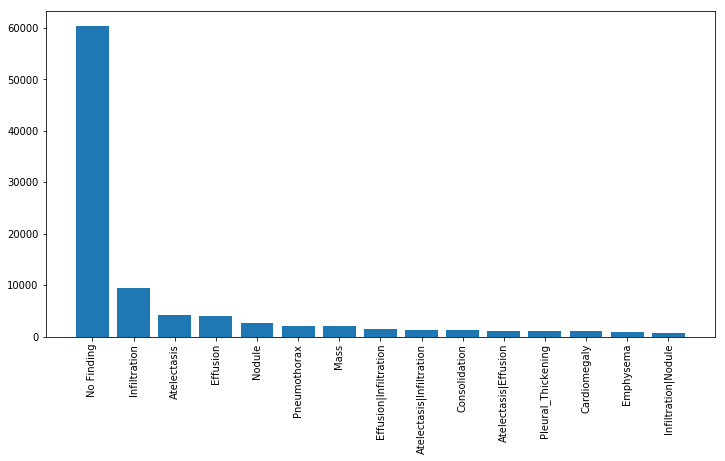

In [3]:
label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 6))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(len(all_labels), all_labels)
for c_label in all_labels:
    df[c_label] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.sample(3)

15 ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
18423,00004893_077.png,No Finding,77,4893,34,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
108916,00029570_008.png,Mass|Pleural_Thickening,8,29570,39,M,PA,2021,2020,0.194311,...,0,0,0,0,1,0,0,1,0,0
25204,00006642_004.png,Infiltration|Nodule,4,6642,58,M,PA,2500,2048,0.171000,...,0,0,0,1,0,0,1,0,0,0


### create HDF5
Here we create an HDF5 with all the relevant label information inside. We can add images later.

In [13]:
import h5py
from tqdm import tqdm

def write_df_as_hdf(out_path,
                    out_df,
                    compression='gzip'):
    with h5py.File(out_path, 'w') as h:
        for k, arr_dict in tqdm(out_df.to_dict().items()):
            try:
                s_data = np.stack(arr_dict.values(), 0)
                try:
                    h.create_dataset(k, data=s_data, compression=
                    compression)
                except TypeError as e:
                    try:
                        h.create_dataset(k, data=s_data.astype(np.string_),
                                         compression=compression)
                    except TypeError as e2:
                        print('%s could not be added to hdf5, %s' % (
                            k, repr(e), repr(e2)))
            except ValueError as e:
                print('%s could not be created, %s' % (k, repr(e)))
                all_shape = [np.shape(x) for x in arr_dict.values()]
                warn('Input shapes: {}'.format(all_shape))

write_df_as_hdf('./chest_xray.h5', df)

100%|██████████| 28/28 [00:03<00:00,  7.81it/s]


In [14]:
# show what is inside
with h5py.File('chest_xray.h5', 'r') as h5_data:
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

Atelectasis (112120,) int64
Cardiomegaly (112120,) int64
Consolidation (112120,) int64
Edema (112120,) int64
Effusion (112120,) int64
Emphysema (112120,) int64
Fibrosis (112120,) int64
Finding Labels (112120,) |S100
Follow-up # (112120,) int64
Height] (112120,) int64
Hernia (112120,) int64
Image Index (112120,) |S16
Infiltration (112120,) int64
Mass (112120,) int64
No Finding (112120,) int64
Nodule (112120,) int64
OriginalImagePixelSpacing[x (112120,) float64
OriginalImage[Width (112120,) int64
Patient Age (112120,) int64
Patient Gender (112120,) |S1
Patient ID (112120,) int64
Pleural_Thickening (112120,) int64
Pneumonia (112120,) int64
Pneumothorax (112120,) int64
Unnamed: 11 (112120,) float64
View Position (112120,) |S2
path (112120,) |S26
y] (112120,) float64


### Preprocessing images
Since the images all look a bit different we use a standard CLAHE algorithm to equalize the histograms in them. We then downscale to 256x256.

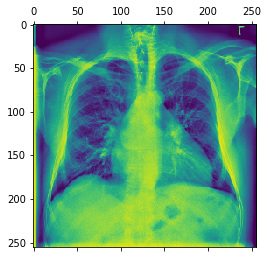

In [15]:
from skimage.transform import resize
OUT_DIM = (256, 256)
def imread_and_normalize(im_path):
    clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_data = np.mean(imread(im_path), 2).astype(np.uint8)
    img_data = clahe_tool.apply(img_data)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    return np.expand_dims(n_img, -1)

test_img = imread_and_normalize(df['path'].values[0])
plt.matshow(test_img[:,:,0])

In [16]:
%%time
# time for 100 images
pre_read_tiles = np.stack(df.sample(100)['path'].map(imread_and_normalize).values,0)

CPU times: user 4.53 s, sys: 3.86 s, total: 8.39 s
Wall time: 2.68 s


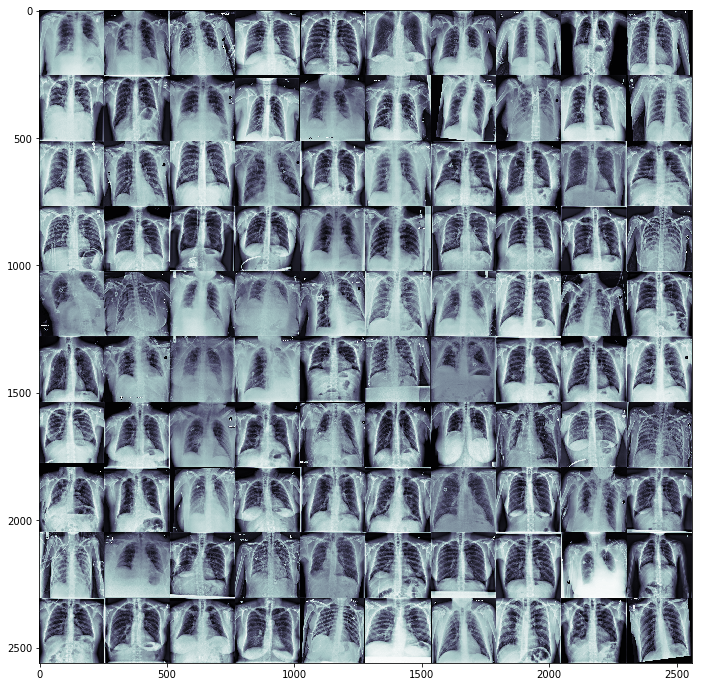

In [17]:
# might as well show-em if we have em
from skimage.util.montage import montage2d
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
ax1.imshow(montage2d(pre_read_tiles[:,:,:,0]), cmap = 'bone')
fig.savefig('overview.png', dpi = 300)

In [18]:
# preallocate output
out_image_arr = np.zeros((df.shape[0],)+OUT_DIM+(1,), dtype=np.uint8)
if False:
    # a difficult to compress array for size approximations
    out_image_arr = np.random.uniform(0, 255,
                                  size = (df.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)

In [19]:
for i, c_path in enumerate(tqdm(df['path'].values)):
    out_image_arr[i] = imread_and_normalize(c_path)

100%|██████████| 112120/112120 [50:32<00:00, 36.97it/s]


In [20]:
# append the array
with h5py.File('chest_xray.h5', 'a') as h5_data:
    h5_data.create_dataset('images', data = out_image_arr, compression = None) # compression takes too long
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

Atelectasis (112120,) int64
Cardiomegaly (112120,) int64
Consolidation (112120,) int64
Edema (112120,) int64
Effusion (112120,) int64
Emphysema (112120,) int64
Fibrosis (112120,) int64
Finding Labels (112120,) |S100
Follow-up # (112120,) int64
Height] (112120,) int64
Hernia (112120,) int64
Image Index (112120,) |S16
Infiltration (112120,) int64
Mass (112120,) int64
No Finding (112120,) int64
Nodule (112120,) int64
OriginalImagePixelSpacing[x (112120,) float64
OriginalImage[Width (112120,) int64
Patient Age (112120,) int64
Patient Gender (112120,) |S1
Patient ID (112120,) int64
Pleural_Thickening (112120,) int64
Pneumonia (112120,) int64
Pneumothorax (112120,) int64
Unnamed: 11 (112120,) float64
View Position (112120,) |S2
images (112120, 256, 256, 1) uint8
path (112120,) |S26
y] (112120,) float64


In [21]:
print('Output File-size %2.2fMB' % (os.path.getsize('chest_xray.h5')/1e6))

Output File-size 7349.65MB
